# Fitting a line to data using MCMC

In this example we will be going over Exercise 6 from [Hogg 2010](http://arxiv.org/abs/1008.4686).  We will be fitting a line to data using a model that rejects outliers using an MCMC sampler.

## Packages being used
+ `numpy`: doing math on arrays
+ `pymc`: this does the heavy lifting for the MCMC code
+ `matplotlib`: plot our results
+ `seaborn`: useful plotting functions
+ `python-graphviz`: plotting pymc models as graphs
+ `pandas`: read in data table

## Relevant documentation
+ introduction to probabilistic programming: https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Prologue/Prologue.ipynb
+ `pymc`: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust-with-outlier-detection.html#linear-model-with-custom-likelihood-to-distinguish-outliers-hogg-method
+ `matplotlib`: https://matplotlib.org/stable/api/pyplot_summary.html
+ how to pick priors: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import aesara.tensor as at
import pandas
import mpl_style

%matplotlib inline
plt.style.use(mpl_style.style1)

### Read in the data
First lets read in the data we will be fitting:

In [31]:
data = pandas.read_csv('data.csv')

x_mean = data.x.mean()
x_std = data.x.std()
y_mean = data.y.mean()
y_std = data.y.std()

# center and scale data
x_center = (data.x - x_mean) / x_std
y_center = (data.y - y_mean) / y_std
sy_center = data.sy / y_std
sx_center = data.sx / x_std

# data order
idx = data.x.argsort()


def un_center(b0_prime, b1_prime, x_mean, x_std, y_mean, y_std):
    b0 = (b0_prime * y_std) - (b1_prime * x_mean * y_std/x_std) + y_mean
    x = x_mean - (x_std / b1_prime) * ((y_mean / y_std) + b0_prime)
    b1 = -b0 / x
    return b0, b1

### What does centering the data do?
We will be fitting a line to our data with a slope and an intercept.  In the original data space these two value are highly correlated, a small change in slope will result in a large change in the intercept and vice-versa.  By centering and scaling the data we are ensuring the intercept is close to 0 and the `x` and `y` values are about the same size.  This reduces the correlation between the two fit parameters (e.g. you can adjust the slope and keep the intercept the same).

### Plot the data
Lets take a look at our data to see what we are fitting:

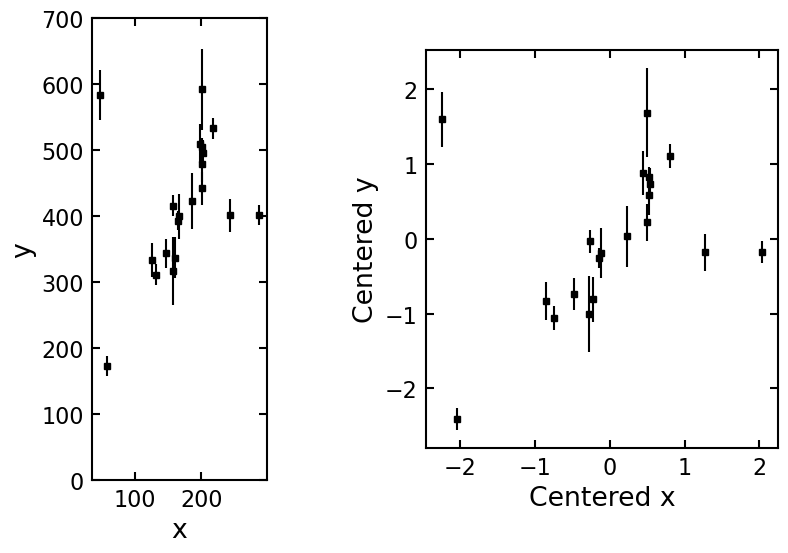

In [32]:
errorbar_kwargs = {
    'ls': 'None',
    'mfc': 'k',
    'mec': 'k',
    'ms': 5,
    'marker': 's',
    'ecolor': 'k'
}

plt.figure(1, figsize=(10, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax1.errorbar(data.x, data.y, data.sy, **errorbar_kwargs)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_ylim(0, 700)
ax1.set_aspect(1)

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.errorbar(x_center, y_center, sy_center, **errorbar_kwargs)
ax2.set_xlabel('Centered x')
ax2.set_ylabel('Centered y')
ax2.set_aspect(1);

## OLS Model
As a starting point we will first build a least squares linear regression model and see how that does.

intercept-centered ~ N(0, 100)
    slope-centered ~ N(0, 100)
         intercept ~ Deterministic(f(intercept-centered, slope-centered))
             slope ~ Deterministic(f(intercept-centered, slope-centered))
        y-centered ~ Deterministic(f(intercept-centered, slope-centered))
                 y ~ Deterministic(f(intercept-centered, slope-centered))
        likelihood ~ N(y-centered, <constant>)

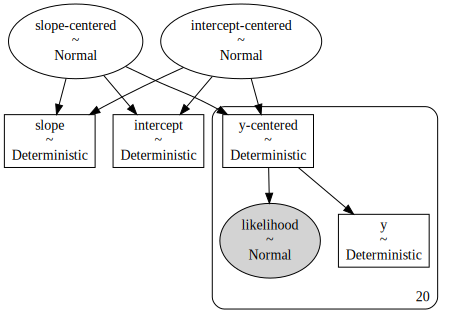

In [33]:
with pm.Model() as mdl_ols:
    # Define weakly informative Normal priors (Ridge regression)
    b0 = pm.Normal('intercept-centered', mu=0, sigma=100)
    b1 = pm.Normal('slope-centered', mu=0, sigma=100)

    # un-center slope and intercept as Deterministic variables so we can plot it later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    intercept = pm.Deterministic('intercept', b0_orig)
    slope = pm.Deterministic('slope', b1_orig)
    
    # Define y_est_center and y_est as a Deterministic variables so we can plot it later
    y_est_centered = pm.Deterministic('y-centered', b0 + b1 * x_center)
    y_est = pm.Deterministic('y', (y_est_centered * y_std) + y_mean)
    likelihood = pm.Normal('likelihood', mu=y_est_centered, sigma=sy_center, observed=y_center)

display(mdl_ols)
display(pm.model_to_graphviz(mdl_ols))

We can see the likelihood of the fit given the data is defined as a Normal distribution with scatter defined by observed y-errors.  The priors chosen for the slope and intercept are weakly informative Normal priors. The use of these particular priors is called Ridge regression.

### Run MCMC
Now we can run the MCMC sampler to find the best fit.

In [62]:
with mdl_ols:
    traces_ols = pm.sample(
        tune=1000,
        draws=1000,
        chains=3,
        cores=3,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [intercept-centered, slope-centered]
INFO:pymc:NUTS: [intercept-centered, slope-centered]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 18 seconds.
INFO:pymc:Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 18 seconds.


The default sampler is NUTS (No U-True Sampler), a powerful sampler that uses the likelihood's gradient information to propose new MC steps. 

### Check for convergence
Lets look at the results and see if the MCMC converged:

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept-centered,-0.195,0.045,-0.279,-0.110,0.001,0.001,2487.0,1872.0,1.0
slope-centered,0.590,0.043,0.504,0.667,0.001,0.001,2848.0,2208.0,1.0


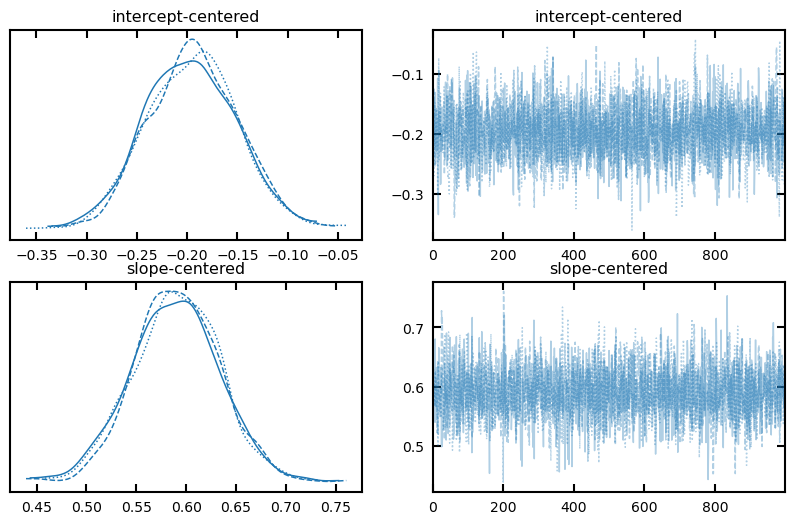

In [63]:
display(pm.summary(
    traces_ols,
    var_names=['intercept-centered', 'slope-centered']
))
pm.plot_trace(
    traces_ols,
    var_names=['intercept-centered', 'slope-centered'],
    figsize=(10, 6)
);

Everything looks good, the `Rhat` values are all close to 1, and the traces have all mixed well.  Since we named the `y_est` variable it is also tracked in every sampling step.  This makes plotting the results easier since we don't need to evaluate the model for every `b0` and `b1` value in the sample.

Lets take a look at the covariance between the fitted intercept and slope.

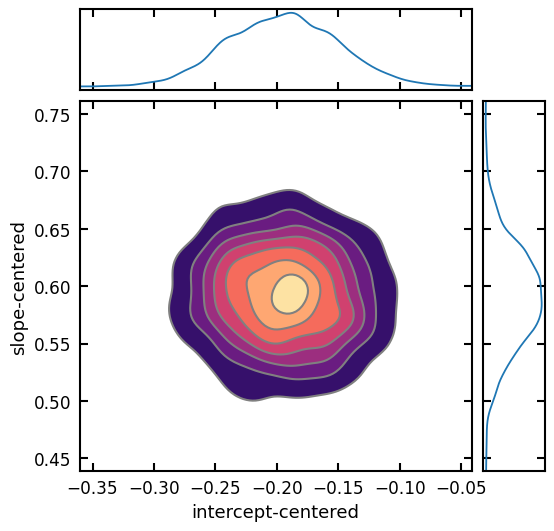

In [64]:
ax = pm.plot_pair(
    traces_ols,
    var_names=['intercept-centered', 'slope-centered'],
    marginals=True,
    kind='kde',
    figsize=[6, 6]
)

Notice how in the centered parameter space these two values are not correlated (as expected), let transform the fit back to the original data space.

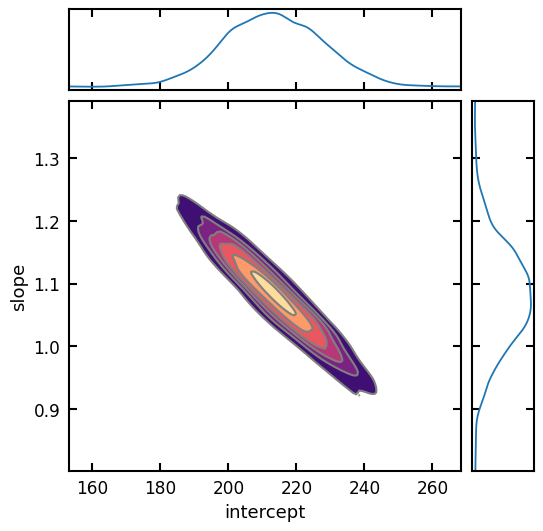

In [65]:
ax = pm.plot_pair(
    traces_ols,
    var_names=['intercept', 'slope'],
    marginals=True,
    kind='kde',
    figsize=[6, 6]
)

Now we can see a large correlation in the fit parameters.  If we tried to run the MCMC sampler in this data space it would have issues.

### Plotting the best fit
Finally we can plot the best fit on the original data.

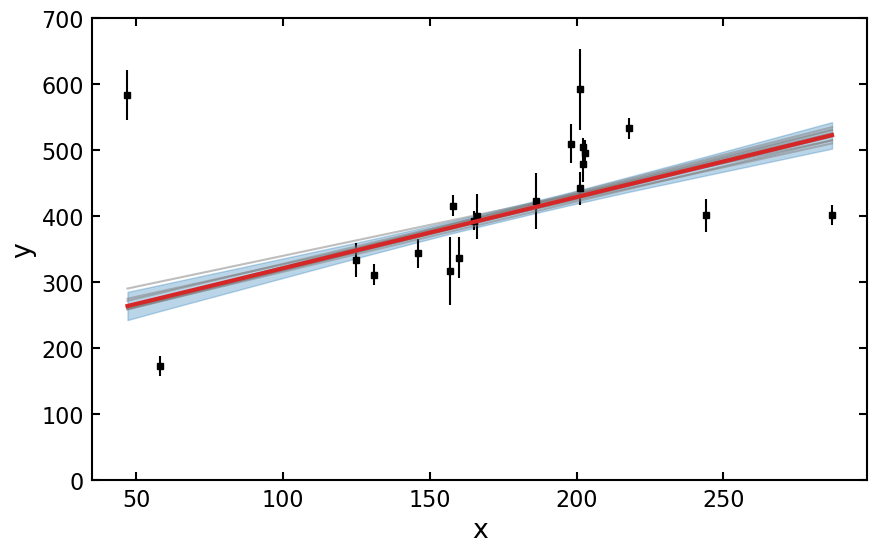

In [66]:
fill_kwargs = {
    'color': 'C0',
    'alpha': 0.3,
    'zorder': 1
}

# un-center and scale
y_est = traces_ols.posterior.y.data.reshape(-1, 20)

# plot original data
plt.figure(2, figsize=(10, 6))
plt.errorbar(data.x, data.y, data.sy, **errorbar_kwargs)

# find 2-sigma and median of best fit lines
y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_est[:, idx],
    [2.5, 50, 97.5],
    axis=0
)

# plot the mean of all best fit lines
plt.plot(data.x[idx], y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(data.x[idx], y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(data.x[idx], y_est[::300].T[idx], alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);

From this plot we can see that the fitted line is being effected by several outliers in the data. Lets build a model that will filter out these outliers.

## Mixture model

To use `pymc3` we need to define the likelihood function we are trying to maximize.  The likelihood we need for this fit is shown in equation 13 of [Hogg 2010](http://arxiv.org/abs/1008.4686):

$$\mathscr{L} \propto \prod_{i=1}^{N}{\left[\frac{1}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp{\left(-\frac{[y_{i} - m x_{i} - b]^2}{2 \sigma_{yi}^{2}}\right)}\right]^{[1-q_{i}]} \times \left[\frac{1}{\sqrt{2 \pi [V_{b}+\sigma_{yi}^{2}]}} \exp{\left( -\frac{[y_{i} - Y_{b}]^2}{2[V_{b}+\sigma_{yi}^{2}]} \right)} \right]^{q_{i}}}$$

$$\{q_{i}\} \sim \text{Bernoulli}(P_b) $$

where $x_{i}, y_{i}, \sigma_{yi}$ are the data from the `.csv` file, $m, b$ are the slope and intercept of the line we are fitting, $q_{i}$ is $1$ if a point is an outlier and $0$ otherwise.  The set of these flags follow a Bernoulli distribution with a probability of being an outlier of $P_b$.  $Y_{b}, V_{b}$ are the parameters of the distribution the outliers are draw from.  See section 3 of Hogg's paper for a full derivation.

Since we will be using a Bayesian approach to this fitting, we need to define priors for our fit parameters $\theta = \left[ m, b, P_b, \{q_{i}\}, Y_b, V_b \right]$.  We will use weakly informative priors in all the parameters.


In [ ]:
with pm.Model() as mdl_signoise:
    # state input data as shared vars
    tsv_x = pm.Data('tsv_x', x_center, mutable=False)
    tsv_y = pm.Data('tsv_y', y_center, mutable=False)
    tsv_sy = pm.Data('tsv_sy', sy_center, mutable=False)

    # define weakly informative Normal priors (Ridge regression)
    b0 = pm.Normal('intercept-centered', mu=0, sigma=100)
    b1 = pm.Normal('slope-centered', mu=0, sigma=100)

    # un-center slope and intercept as Deterministic variables so we can plot it later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    intercept = pm.Deterministic('intercept', b0_orig)
    slope = pm.Deterministic('slope', b1_orig)
    
    # Define y_est_centered and y_est as a Deterministic variables so we can plot it later
    y_est_centered = pm.Deterministic('y-centered', b0 + b1 * tsv_x)
    y_est = pm.Deterministic('y', (y_est_centered * y_std) + y_mean)

    # Define weakly informative priors for the mean and variance of the outliers
    Yb = pm.Normal('Yb', mu=0, sigma=10, initval=0.0)
    Vb = pm.InverseGamma('Vb', 2, 5, initval=1.0)

    # crate in/outlier distributions to get logL evaluated on observed data
    in_rv = pm.Normal.dist(mu=y_est_centered, sigma=tsv_sy)
    logL_in = pm.logp(in_rv, tsv_y)
    
    sigma_out = pm.math.sqrt(Vb + tsv_sy**2)
    out_rv = pm.Normal.dist(mu=Yb, sigma=sigma_out)
    logL_out = pm.logp(out_rv, tsv_y)

    # Define Bernoulli inlier / outlier probability (P_b) with uniform prior
    Pb = pm.Uniform('Pb', lower=0.0, upper=1.0, initval=0.5)
    qi = pm.Bernoulli(
        'qi',
        p=Pb,
        shape=tsv_x.eval().shape[0],
        initval=np.random.rand(tsv_x.eval().shape[0]) < 0.5
    )

    # Use custom likelihood
    potential = pm.Potential(
        'likelihood',
        ((1 - qi) * logL_in).sum() + (qi * logL_out).sum()
    )
    
display(mdl_signoise)

intercept-centered ~ N(0, 100)
    slope-centered ~ N(0, 100)
                Yb ~ N(0, 10)
                Vb ~ InvGamma(2, 5)
                Pb ~ U(0, 1)
                qi ~ Bern(Pb)
         intercept ~ Deterministic(f(intercept-centered, slope-centered))
             slope ~ Deterministic(f(intercept-centered, slope-centered))
        y-centered ~ Deterministic(f(intercept-centered, slope-centered))
                 y ~ Deterministic(f(intercept-centered, slope-centered))
        likelihood ~ Potential(f(qi, Vb, Yb, intercept-centered, slope-centered))

In [55]:
with mdl_signoise:
    traces_signoise = pm.sample(
        tune=4000,
        draws=1000,
        chains=3,
        cores=3,
        init="jitter+adapt_diag_grad",
        nuts={"target_accept": 0.99},
        return_inferencedata=True
    )

Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc:Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
INFO:pymc:CompoundStep
>NUTS: [intercept-centered, slope-centered, Yb, Vb, Pb]
INFO:pymc:>NUTS: [intercept-centered, slope-centered, Yb, Vb, Pb]
>BinaryGibbsMetropolis: [qi]
INFO:pymc:>BinaryGibbsMetropolis: [qi]


Sampling 3 chains for 4_000 tune and 1_000 draw iterations (12_000 + 3_000 draws total) took 42 seconds.
INFO:pymc:Sampling 3 chains for 4_000 tune and 1_000 draw iterations (12_000 + 3_000 draws total) took 42 seconds.


If you see any warning messages about divergent chains it typically means one or more of your priors are not set to reasonable distributions, or some of your parameters have high covariance and should be rescaled.  In the above example if the prior on $V_b$ is set to be `Uniform` on the the $\log(V_b)$ (as suggested by Hogg 2010) it will lead to divergent chains, but changing this to be an `InverseGamma` function clears up the issues.  Even with this change we also need to increase `target_accept` from its default of 0.8 to 0.99 and use 4000 tuning samples to avoid divergent chains.

### Note about priors
Often times the priors you use will effect how fast the sampler will run.  If you are getting a small number of draws/s try changing all your priors to `Normal` distributions to see if it runs any faster (`Uniform` priors can be very slow if they cover a large range).

See https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations for other tips about picking priors.

### Check for convergence

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept-centered,0.032,0.057,-0.071,0.143,0.001,0.001,1673.0,1472.0,1.0
slope-centered,1.246,0.071,1.119,1.374,0.002,0.001,1761.0,912.0,1.0
Vb,2.467,2.659,0.520,5.393,0.093,0.065,1443.0,1356.0,1.0
Yb,0.283,0.810,-1.204,1.841,0.024,0.019,1365.0,915.0,1.0
Pb,0.265,0.117,0.073,0.487,0.003,0.002,1428.0,1670.0,1.0


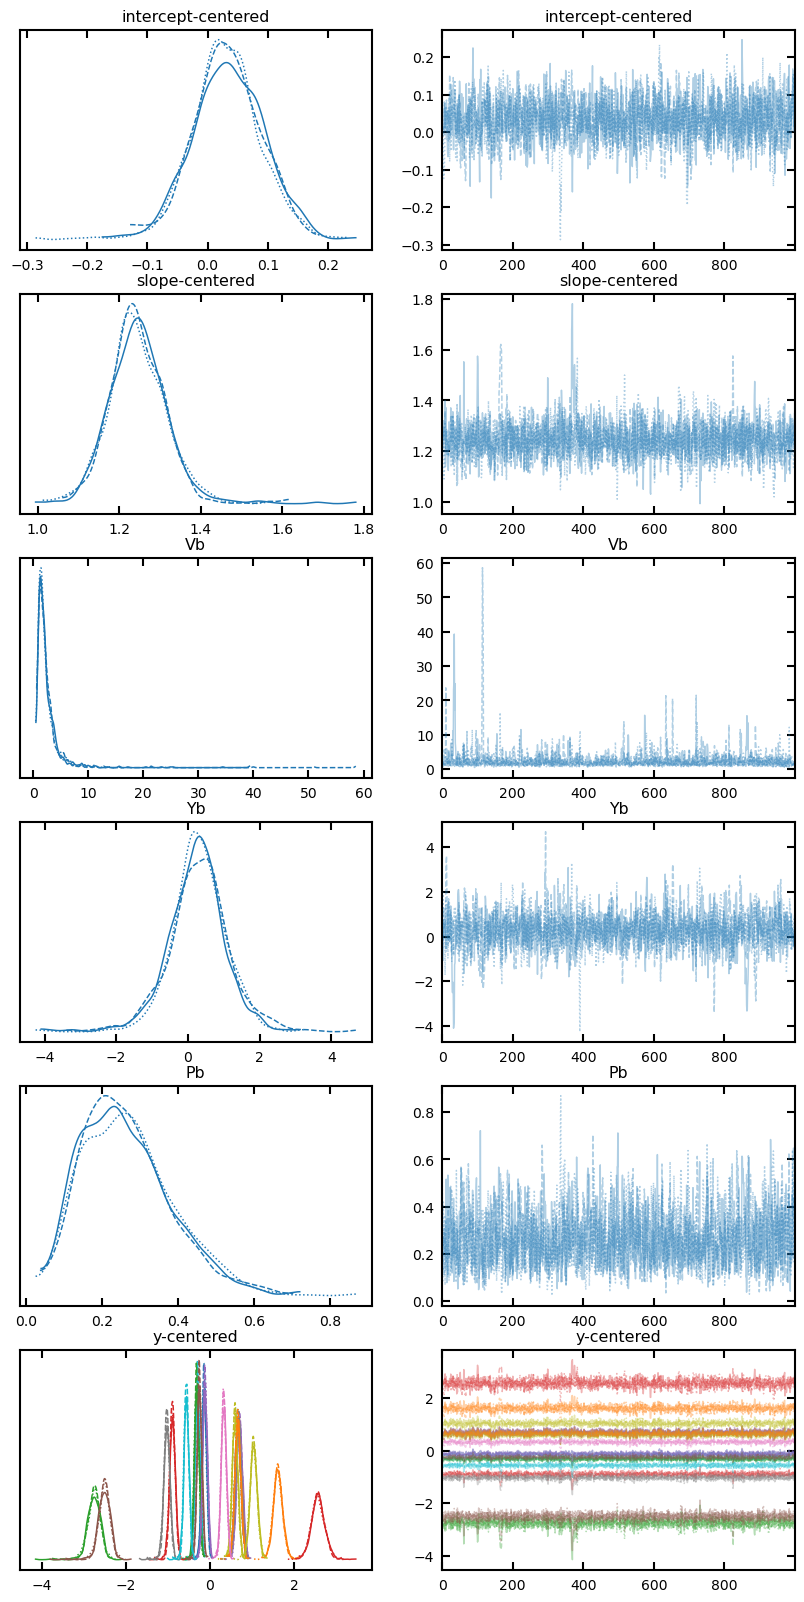

In [56]:
display(pm.summary(
    traces_signoise,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'Pb'
    ]
))
pm.plot_trace(
    traces_signoise,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'Pb',
        'y-centered'
    ],
    figsize=(10, 20)
);

As before we can see the `Rhat` values are all close to 1 and all the chains are well mixed.

Lets take a look at a corner plot of these fit variables after converting the slope and intercept back into the original data space.

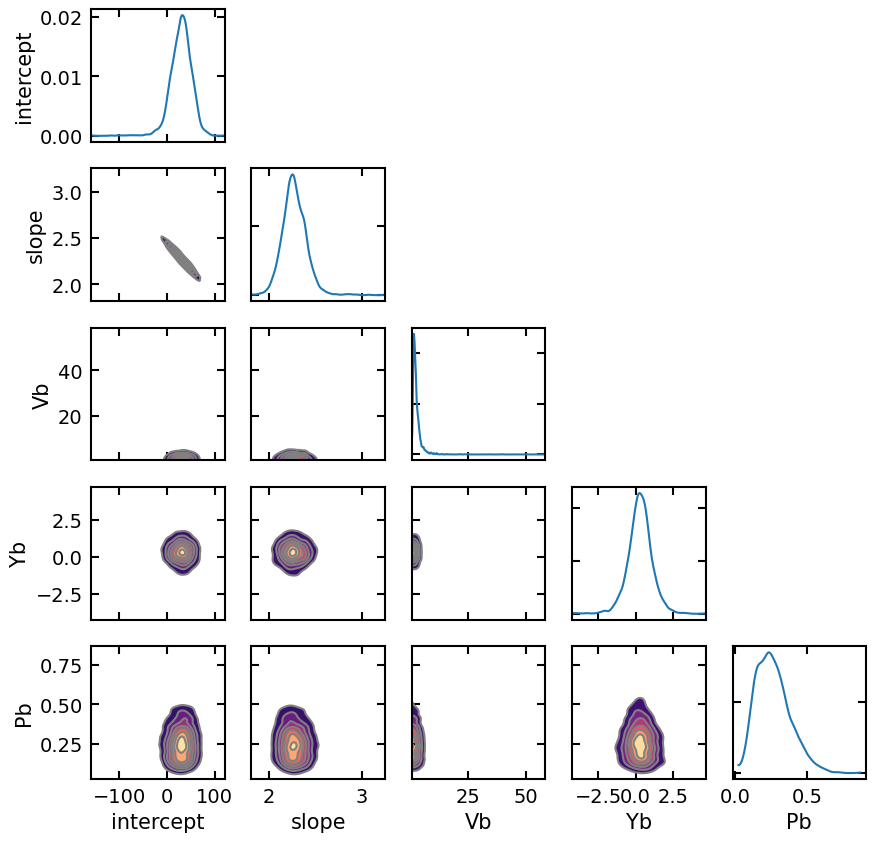

In [58]:
ax = pm.plot_pair(
    traces_signoise,
    var_names=['intercept', 'slope', 'Vb', 'Yb', 'Pb'],
    marginals=True,
    kind='kde',
    figsize=[10, 10]
)

As before we see a strong correlation between the slope and intercept.

### Finding the outliers
Unlike the OLS fit, this fit also has information about the probability of each point being an outlier ($q_i$).  For each step in the MC chain a `True` or `False` array was recored indicating what points belonged to the outlier distribution.  Averaging these across each step in the chin gives us the probability of each point being an outlier.

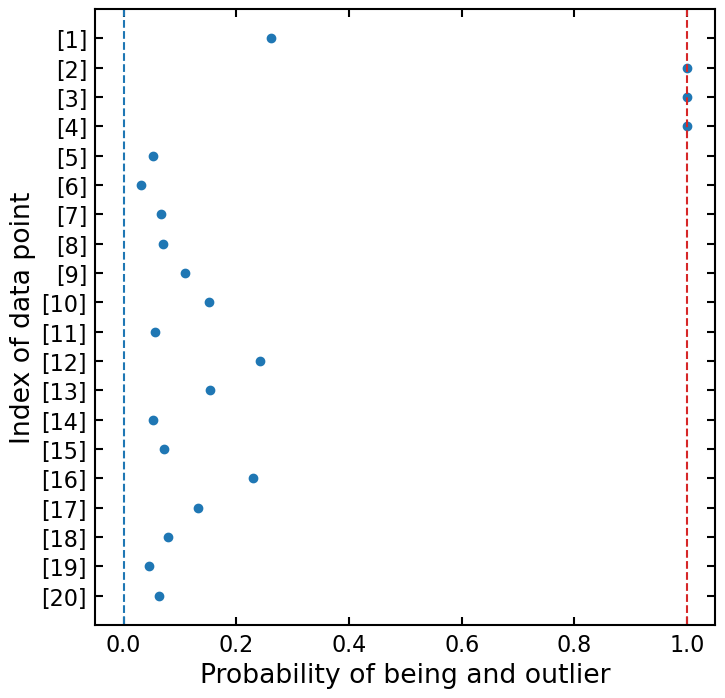

In [59]:
plt.figure(3, figsize=(8, 8))
avg_q = traces_signoise.posterior.qi.data.reshape(-1, 20).mean(axis=0)

plt.plot(avg_q, range(20), 'o')
plt.vlines([0, 1], -1, 20, ['C0', 'C3'], '--')
ax=plt.gca()
ax.set_yticks(range(20))
ax.set_yticklabels(['[{0}]'.format(i) for i in data.ID])
plt.xlabel('Probability of being and outlier')
plt.ylabel('Index of data point')
plt.ylim(20, -1);

From this plot we can see that three points are clearly marked as being outliers 100% of the time.  All of the other points are classed as outliers less that 33% of the time.

Lets take a closer look at the posterior distribution for the fraction of data points belonging to the outlier distribution ($P_b$).  Looking at the above plot we might expect this to peak at $3/20 = 0.15$. 

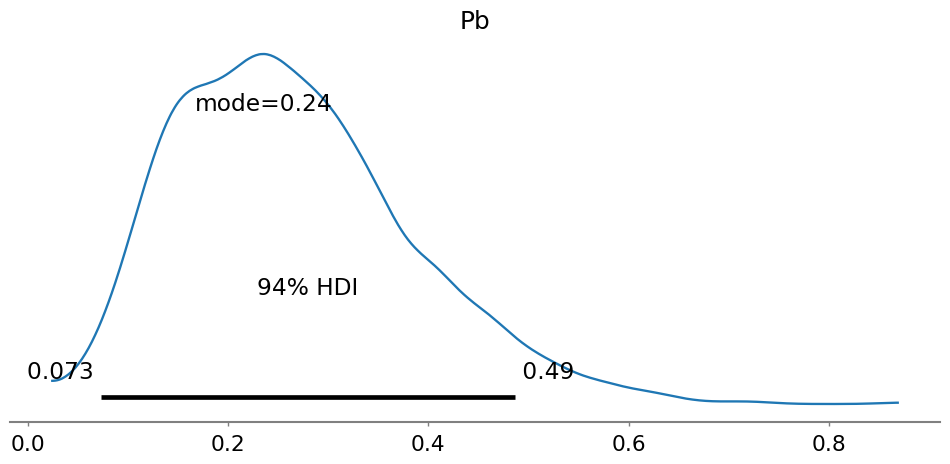

In [60]:
pm.plot_posterior(
    traces_signoise,
    var_names=['Pb'],
    figsize=(12, 5),
    point_estimate='mode'
);

Interestingly it peaks at 0.21, so we would expect 4 to 5 outliers instead of 3, so where does this number come from?

In [61]:
avg_q.sum() / 20

0.24338333333333328

That is closer to the peak of the posterior.  This is taking the sum of the outlier fraction for *all* points into account.  So overall there are "5" outliers but 2 of those are split among 17 data points.

### Plotting the fits
As before lets plot these fits on the original data points but this time we will highlight the outliers.

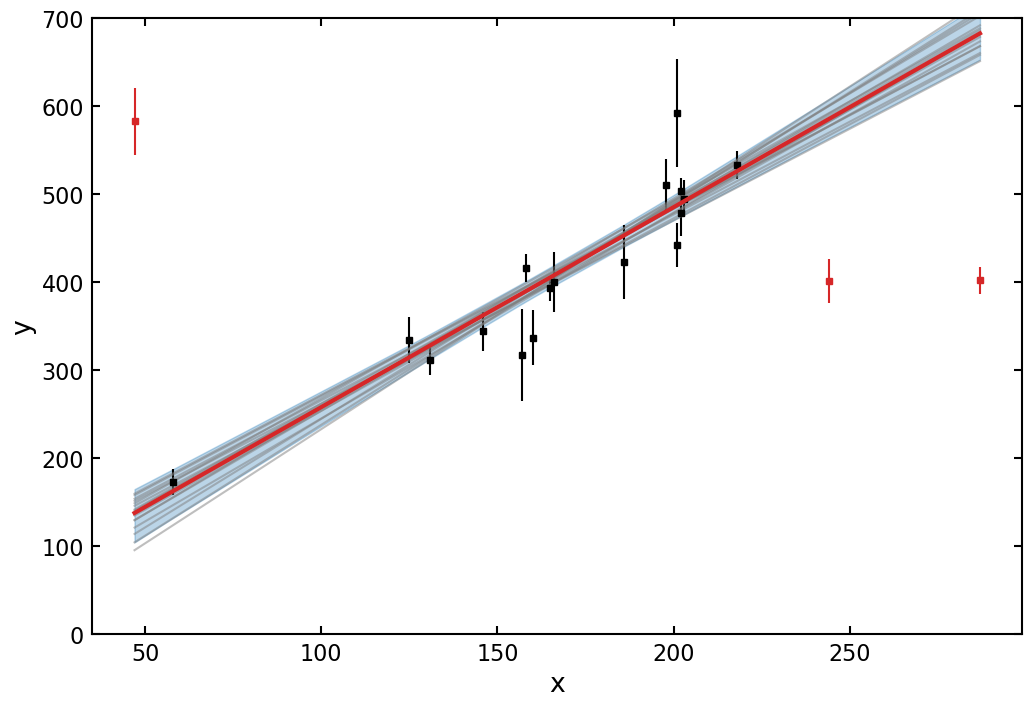

In [44]:
y_est = traces_signoise.posterior.y.data.reshape(-1, 20)

# find the outliers
outliers = avg_q > 0.8

plt.figure(4, figsize=(12, 8))
# plot inliers
plt.errorbar(data.x[~outliers], data.y[~outliers], data.sy[~outliers], **errorbar_kwargs)

# plot outliers
plt.errorbar(
    data.x[outliers],
    data.y[outliers],
    data.sy[outliers],
    ls='None',
    mfc='C3',
    mec='C3',
    ms=5,
    marker='s',
    ecolor='C3'
)

y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_est[:, idx],
    [2.5, 50, 97.5],
    axis=0
)

# plot the mean of all best fit lines
plt.plot(data.x[idx], y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(data.x[idx], y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(data.x[idx], y_est[::200].T[idx], alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);

Looking much better!  Our best fit line goes through all the data points without being confused by the outliers.

### What if you don't care about $q_i$?

If you don't care about the $q_i$ value for each data point you they can be marginalized over.  Doing this results in a normal mixture model, and pymc3 has this built in.  The plus side to using this kind of model is every variable is continuous ($q_i$ was discrete) making it easier to sample from and faster to converge.

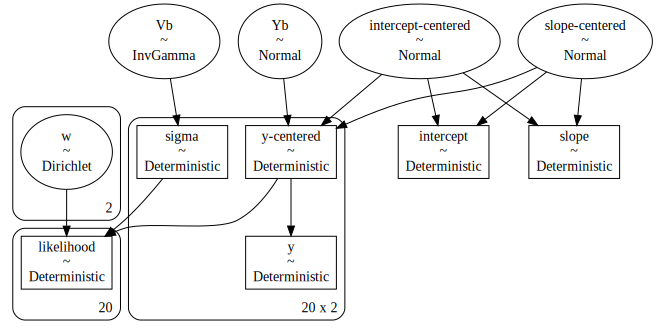

In [45]:
with pm.Model() as mixture:
    w = pm.Dirichlet('w', np.array([0.8, 0.2]))
    b0 = pm.Normal('intercept-centered', mu=0, sigma=100, initval=0)
    b1 = pm.Normal('slope-centered', mu=0, sigma=100, initval=1.2)
    
    # un-center slope and intercept as Deterministic variables so we can plot it later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    intercept = pm.Deterministic('intercept', b0_orig)
    slope = pm.Deterministic('slope', b1_orig)
    
    Yb = pm.Normal('Yb', mu=0, sigma=10, initval=0)
    Vb = pm.InverseGamma('Vb', 2, 5, initval=2.5)
    
    # Define y_est_centered and y_est as a Deterministic variables so we can plot it later
    y_est_centered = pm.Deterministic(
        'y-centered',
        at.stack(
            [
                b0 + b1 * x_center,
                np.ones_like(x_center) * Yb
            ],
            axis=1
        )
    )
    y_est = pm.Deterministic('y', (y_est_centered * y_std) + y_mean)
    
    sigma = pm.Deterministic(
        'sigma',
        at.stack(
            [
                sy_center,
                np.sqrt(np.array(sy_center)**2 + Vb)
            ],
            axis=1
        )
    )
    likelihood = pm.NormalMixture(
        'likelihood',
        w,
        y_est_centered,
        sigma=sigma,
        observed=y_center
    )

display(pm.model_to_graphviz(mixture))

$w$ is a two element array that is equivalent to $[1-P_b, P_b]$.  These are the coefficients used to say how much of the likelihood comes from the inlier and outlier distributions.

In [46]:
with mixture:
    traces_mixture = pm.sample(
        tune=1000,
        draws=1000,
        chains=3,
        cores=3,
        init='jitter+adapt_diag_grad',
        nuts={"target_accept": 0.99},
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
INFO:pymc:Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [w, intercept-centered, slope-centered, Yb, Vb]
INFO:pymc:NUTS: [w, intercept-centered, slope-centered, Yb, Vb]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 28 seconds.
INFO:pymc:Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 28 seconds.


### Check for convergence

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept-centered,0.034,0.056,-0.069,0.145,0.001,0.001,3016.0,2074.0,1.0
slope-centered,1.246,0.066,1.124,1.361,0.001,0.001,2737.0,1419.0,1.0
Vb,2.377,1.777,0.567,5.238,0.043,0.031,2270.0,1641.0,1.0
Yb,0.288,0.784,-1.145,1.828,0.018,0.016,2043.0,1552.0,1.0
w[0],0.774,0.114,0.557,0.957,0.002,0.002,2540.0,1723.0,1.0
w[1],0.226,0.114,0.043,0.443,0.002,0.002,2540.0,1723.0,1.0


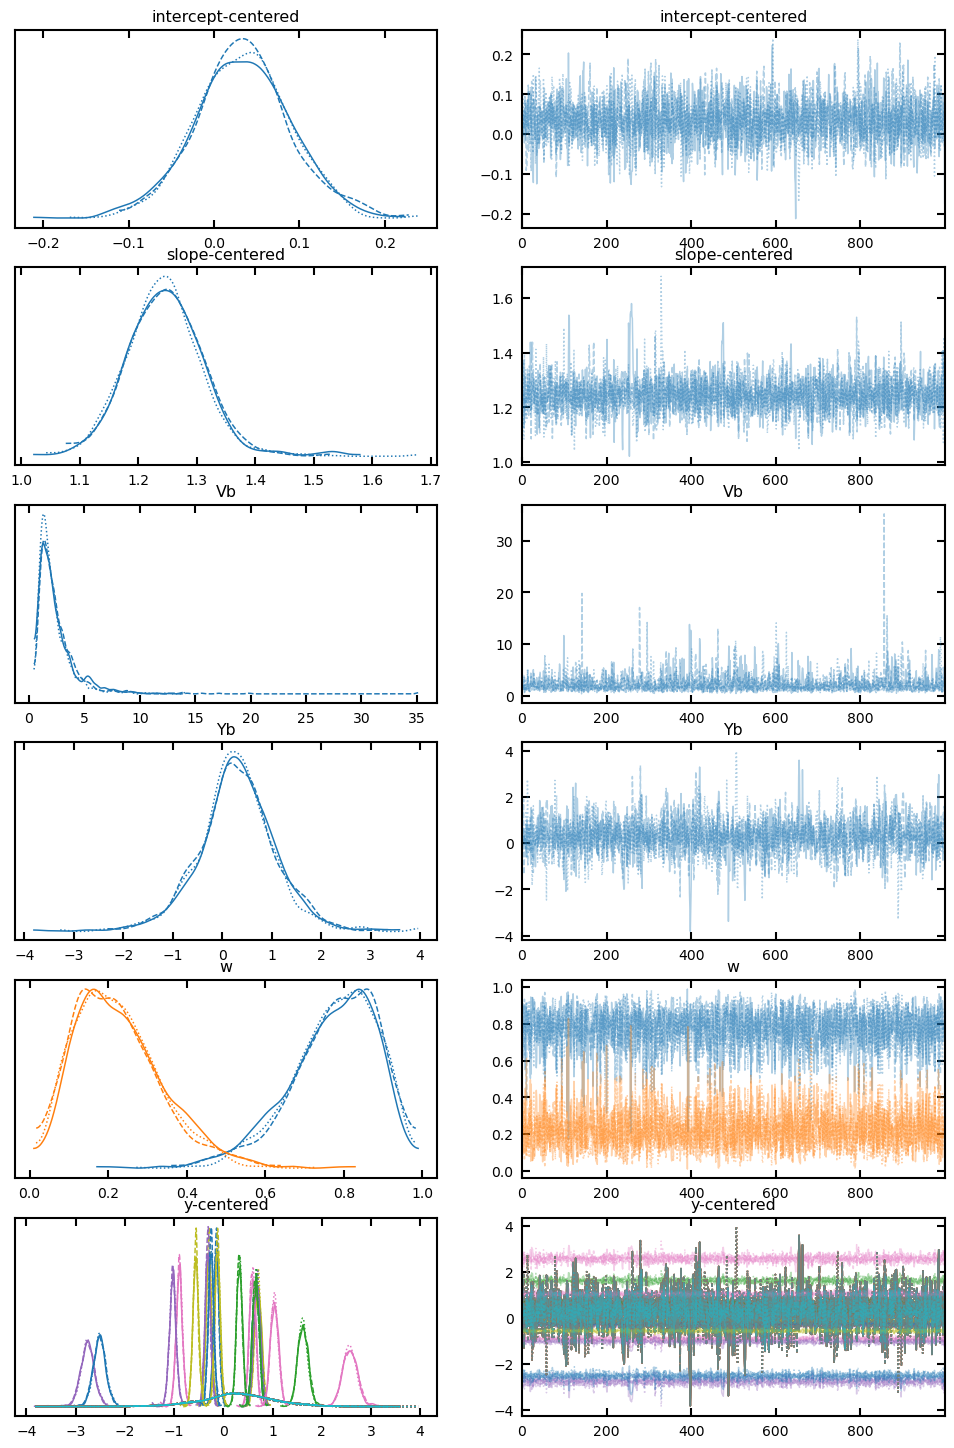

In [47]:
display(pm.summary(
    traces_mixture,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'w'
    ]
))
pm.plot_trace(
    traces_mixture,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'w',
        'y-centered'
    ],
    figsize=(12, 18)
);

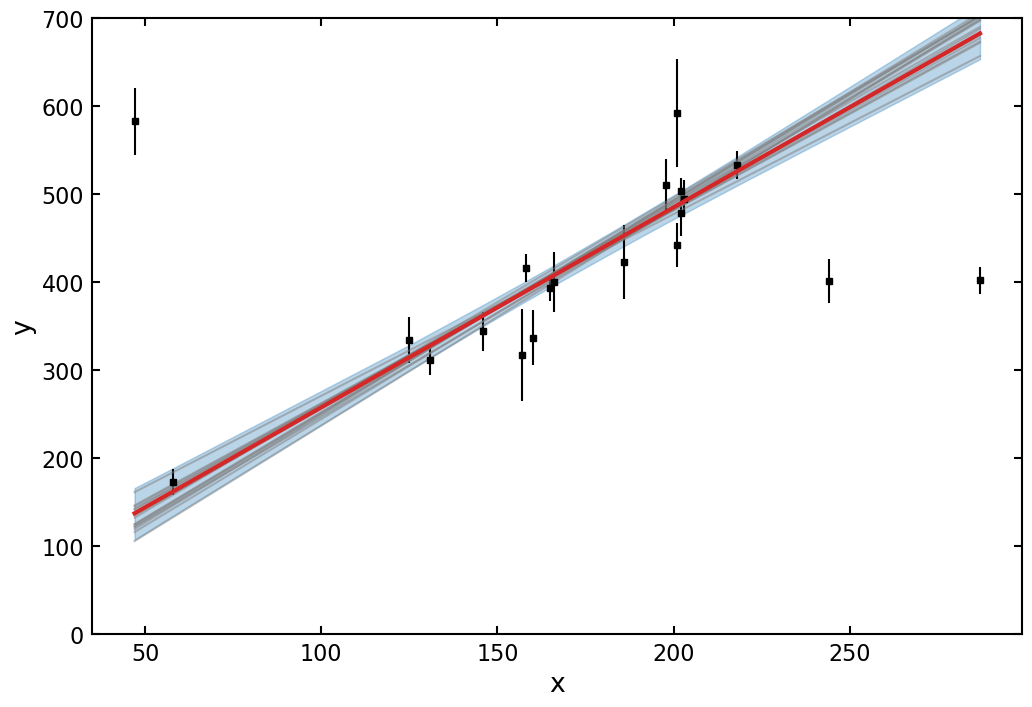

In [48]:
# un-center and scale
y_est = traces_mixture.posterior.y.data[..., 0].reshape(-1, 20)

plt.figure(4, figsize=(12, 8))
# plot non-outliers
plt.errorbar(data.x, data.y, data.sy, **errorbar_kwargs)

y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_est[:, idx],
    [2.5, 50, 97.5],
    axis=0
)

# plot the mean of all best fit lines
plt.plot(data.x[idx], y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(data.x[idx], y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(data.x[idx], y_est[::200].T[idx], alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);

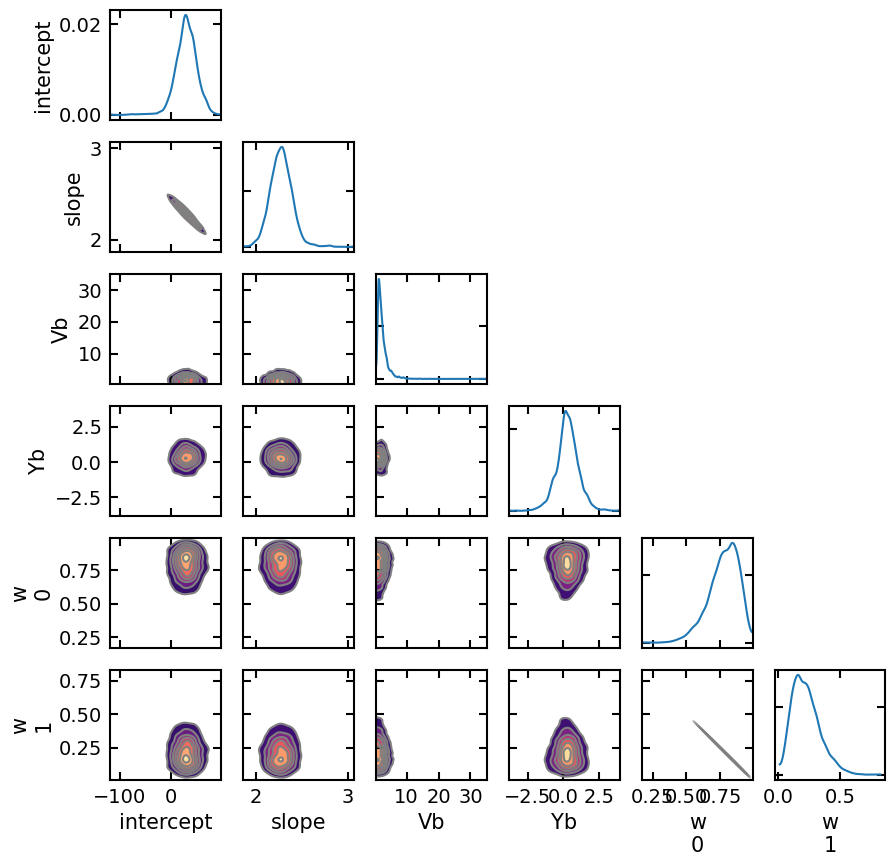

In [50]:
ax = pm.plot_pair(
    traces_mixture,
    var_names=['intercept', 'slope', 'Vb', 'Yb', 'w'],
    marginals=True,
    kind='kde',
    figsize=[10, 10]
)

Everything looks good.  If you compare the values in the summary table to the values found in the previous fit they are in agreement for all values.

## How to deal with errors in the $x$ direction

Up until now we have only taken into account the errorbars in the $y$ direction. If you also wanted to account for the errors in the $x$ direction (assuming there are no covariances) the OLS model would look like this:

intercept-centered ~ N(0, 100)
    slope-centered ~ N(0, 100)
        x-centered ~ N(0, 50)
         intercept ~ Deterministic(f(intercept-centered, slope-centered))
             slope ~ Deterministic(f(intercept-centered, slope-centered))
        y-centered ~ Deterministic(f(x-centered, intercept-centered, slope-centered))
      likelihood-x ~ N(x-centered, <constant>)
      likelihood-y ~ N(y-centered, <constant>)

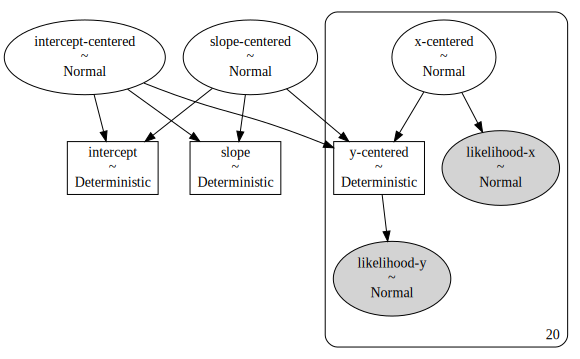

In [51]:
with pm.Model() as mdl_ols_sx:
    b0 = pm.Normal('intercept-centered', mu=0, sigma=100)
    b1 = pm.Normal('slope-centered', mu=0, sigma=100)
    
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    intercept = pm.Deterministic('intercept', b0_orig)
    slope = pm.Deterministic('slope', b1_orig)
    
    x_est_centered = pm.Normal('x-centered', mu=0, sigma=50, shape=len(x_center))
    likelihood_x = pm.Normal('likelihood-x', mu=x_est_centered, sigma=sx_center, observed=x_center)

    y_est_centered = pm.Deterministic('y-centered', b0 + b1 * x_est_centered)
    likelihood_y = pm.Normal('likelihood-y', mu=y_est_centered, sigma=sy_center, observed=y_center)

display(mdl_ols_sx)
display(pm.model_to_graphviz(mdl_ols_sx))

This looks much like the model before, except this time we assume a `Normal` prior on the $x$ positions and add in a second likelihood using the observed $x$ data.

### Note
This is a case where placing a `Uniform` prior on $x_{est}$ will cause it to take much longer to run (over 20 mins as opposed to 20 secs).

In [52]:
with mdl_ols_sx:
    traces_ols_2 = pm.sample(
        tune=1000,
        draws=1000,
        chains=3,
        cores=3,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [intercept-centered, slope-centered, x-centered]
INFO:pymc:NUTS: [intercept-centered, slope-centered, x-centered]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 16 seconds.
INFO:pymc:Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept-centered,-0.165,0.051,-0.264,-0.074,0.001,0.000,5952.0,2341.0,1.0
slope-centered,0.706,0.052,0.618,0.811,0.001,0.001,5052.0,2770.0,1.0


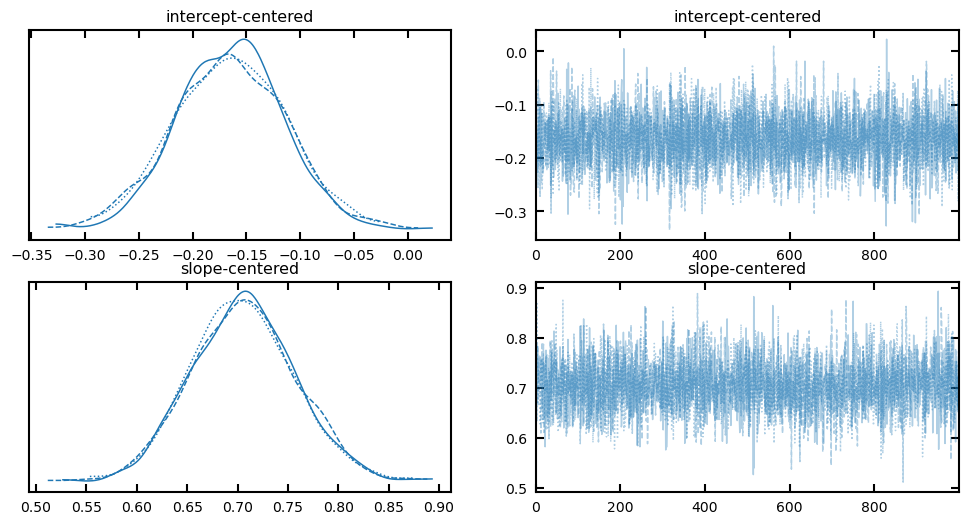

In [53]:
display(pm.summary(
    traces_ols_2,
    var_names=['intercept-centered', 'slope-centered']
))
pm.plot_trace(
    traces_ols_2,
    var_names=['intercept-centered', 'slope-centered'],
    figsize=(12, 6)
);

Care should be taken when plotting these results as each $y_{est}$ has been calculated using slightly different $x_{est}$ values, so they can't be averaged as nicely as before.

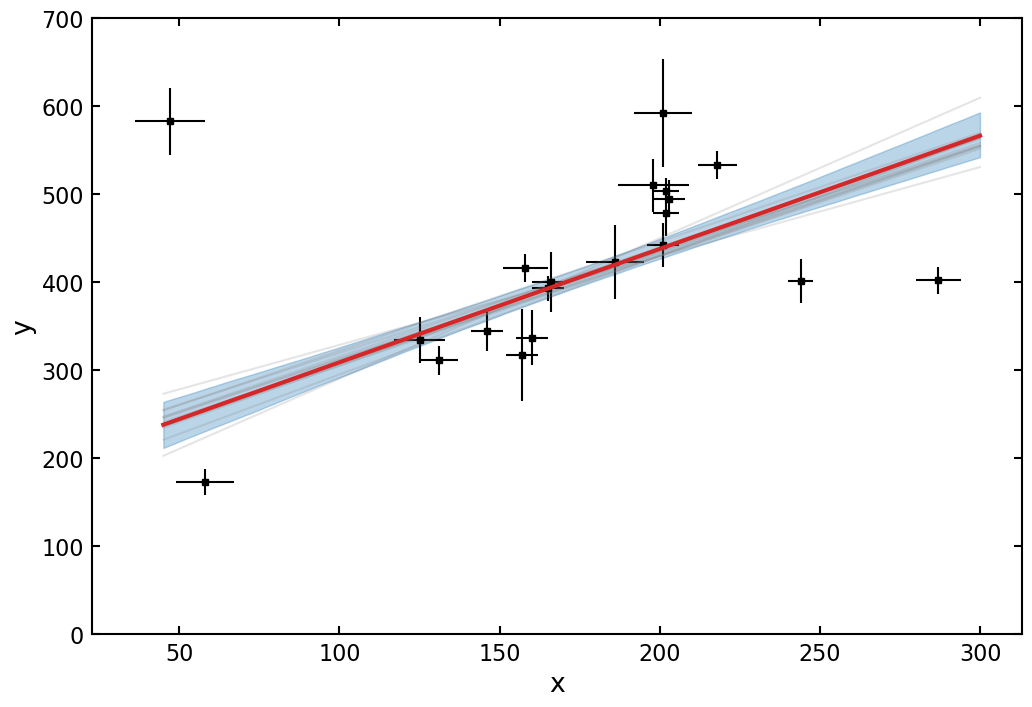

In [54]:
# get y_est evaluated at all the same x positions
x_eval = np.linspace(45, 300, 200)
y_eval = traces_ols_2.posterior.slope.data.reshape(-1, 1) * x_eval + traces_ols_2.posterior.intercept.data.reshape(-1, 1)

# get 2-sigma region and median
y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_eval,
    [2.5, 50, 97.5],
    axis=0
)

plt.figure(5, figsize=(12, 8))
plt.errorbar(data.x, data.y, data.sy, data.sx, **errorbar_kwargs)

# plot the mean of all best fit lines
plt.plot(x_eval, y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(x_eval, y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(x_eval, y_eval[::250].T, alpha=0.2, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);

A similar setup can be used in either of the mixture models used above.